<a href="https://colab.research.google.com/github/ianvictorpaulin225/Python-for-data-Science-Project-X/blob/main/model-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
from torchvision import transforms
from PIL import Image
from collections import defaultdict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
path = kagglehub.dataset_download("tapakah68/facial-emotion-recognition")
print("Path to dataset:", path)

cuda
Path to dataset: /root/.cache/kagglehub/datasets/tapakah68/facial-emotion-recognition/versions/2


### Functions and Models

In [ ]:
def evaluate_accuracy(net, dataloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the correct device
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def show_batch(loader, classes, n=8):

    images, labels = next(iter(loader))

    images = images * 0.5 + 0.5

    plt.figure(figsize=(15,3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].permute(1,2,0).cpu().numpy()
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Corrected the input size for fc1 based on calculations: 16 * 21 * 21 = 7056
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #These are logits
        return x

### Data Loading

In [ ]:
import cv2
import os
from collections import defaultdict

#Manual crop function
def smart_face_crop(img, target_size=96):
    h, w = img.shape[:2]

    if h > w:
        # Portrait orientation - bias crop toward top
        crop_size = w
        y_start = int(h * 0.15)
        if y_start + crop_size > h:
            y_start = h - crop_size
        x_start = 0
    elif w > h:
        # Landscape orientation - center horizontally
        crop_size = h
        x_start = (w - crop_size) // 2
        y_start = 0
    else:
        # Square - center crop
        crop_size = min(h, w)
        y_start = (h - crop_size) // 2
        x_start = (w - crop_size) // 2

    img_cropped = img[y_start:y_start+crop_size, x_start:x_start+crop_size]
    img_resized = cv2.resize(img_cropped, (target_size, target_size))
    return img_resized

# face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_and_resize_face(img, target_size=96):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) > 0:
        # Use largest detected face
        x, y, w, h = max(faces, key=lambda rect: rect[2]*rect[3])
        img_cropped = img[y:y+h, x:x+w]
        img_resized = cv2.resize(img_cropped, (target_size, target_size))
        return img_resized, True
    else:
        # Fallback: smart crop
        return smart_face_crop(img, target_size), False

image_data_with_person = []
person_to_indices = defaultdict(list)
total_files = 0
faces_detected = 0
center_cropped = 0
idx = 0

print("Loading images with face detection...")
print("="*60)

for root, dirs, files in os.walk(path):
    folder_name = os.path.basename(root)
    if not folder_name.isdigit():
        continue
    person_id = folder_name

    for file in files:
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        total_files += 1
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)

        if img is None:
            print(f" Failed to load: {file}")
            continue

        emotion = os.path.splitext(file)[0]

        # Detect face or smart crop
        img_resized, face_found = extract_and_resize_face(img, target_size=96)

        if face_found:
            faces_detected += 1
        else:
            center_cropped += 1

        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        image_data_with_person.append({
            'image': img_gray,
            'emotion': emotion,
            'person': person_id,
            'index': idx,
            'face_detected': face_found
        })

        person_to_indices[person_id].append(idx)
        idx += 1

        if total_files % 20 == 0:
            print(f"Processed {total_files} images... (Faces: {faces_detected}, Crops: {center_cropped})")

print(f"\n{'='*60}")
print(f"Total images: {len(image_data_with_person)}")
print(f"Faces detected: {faces_detected} ({faces_detected/len(image_data_with_person)*100:.1f}%)")
print(f"Center cropped (no face): {center_cropped} ({center_cropped/len(image_data_with_person)*100:.1f}%)")



Loading images with face detection...
Processed 20 images... (Faces: 20, Crops: 0)
Processed 40 images... (Faces: 40, Crops: 0)
Processed 60 images... (Faces: 60, Crops: 0)
Processed 80 images... (Faces: 80, Crops: 0)
Processed 100 images... (Faces: 100, Crops: 0)
Processed 120 images... (Faces: 120, Crops: 0)
Processed 140 images... (Faces: 140, Crops: 0)

Total images: 152
✓ Faces detected: 150 (98.7%)
⚠ Center cropped (no face): 2 (1.3%)
Unique people: 19



### Split the people

In [ ]:
people = list(person_to_indices.keys())
np.random.seed(42)
np.random.shuffle(people)

n_train_people = int(0.8 * len(people))
train_people = set(people[:n_train_people])
test_people = set(people[n_train_people:])

print(f"\nTrain people: {sorted(train_people, key=int)}")
print(f"Test people: {sorted(test_people, key=int)}")


Train people (15): ['1', '2', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18']
Test people (4): ['0', '3', '4', '12']


### Train-Test Split

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

for item in image_data_with_person:
    if item['person'] in train_people:
        train_images.append(item['image'])
        train_labels.append(item['emotion'])
    else:
        test_images.append(item['image'])
        test_labels.append(item['emotion'])

le = LabelEncoder()
all_emotions = [item['emotion'] for item in image_data_with_person]
le.fit(all_emotions)

print(f"\nEmotion classes: {list(le.classes_)}")

train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)

X_train = np.array(train_images, dtype=np.float32) / 255.0
X_test = np.array(test_images, dtype=np.float32) / 255.0

print(f"\nTrain set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")
print(f"Image shape: {X_train[0].shape}")  # Should be (96, 96)


class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # Keep as numpy
        self.images = images  # (N, 96, 96) numpy array
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # (96, 96) numpy array
        label = self.labels[idx]
    # Convert to tensor and add channel dimension
        image = torch.FloatTensor(image).unsqueeze(0)  # (96, 96) -> (1, 96, 96)
        return image, label


Emotion classes: [np.str_('Anger'), np.str_('Contempt'), np.str_('Disgust'), np.str_('Fear'), np.str_('Happy'), np.str_('Neutral'), np.str_('Sad'), np.str_('Surprised')]

Train set: 120 images
Test set: 32 images
Image shape: (96, 96)


### Get sample pic

1


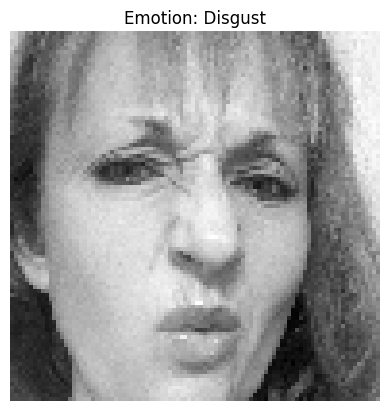

In [ ]:

# Pick a random sample index
sample_idx = np.random.randint(0, len(X_train))
print(sample_idx)

# Get the image and label
sample_image = X_train[sample_idx]  # shape (96, 96)
sample_label_encoded = train_labels_encoded[sample_idx]
sample_label = le.inverse_transform([sample_label_encoded])[0]

# Display the image
plt.imshow(sample_image, cmap='gray')
plt.title(f"Emotion: {sample_label}")
plt.axis('off')
plt.show()

### Create Datasets

In [ ]:
train_dataset = FERDataset(X_train, train_labels_encoded)
test_dataset = FERDataset(X_test, test_labels_encoded)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
net = Net().to(device)

crit = nn.CrossEntropyLoss()  #Built-in softmax!
opti = optim.Adam(net.parameters(), lr=0.003)

In [ ]:
import torch

batch_losses = []
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []


def train_with_early_stopping(net, epochs, train_loader, test_loader, criterion, optimizer, patience):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)  # Moving model here seems to fix an issue of variable being seperated to gpu/cpu
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # Track batch loss
            batch_losses.append(loss.item())

            running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y).sum().item()
            total_train += y.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        net.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = net(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y_val).sum().item()
                total_val += y_val.size(0)

        val_loss /= len(test_loader.dataset)
        val_accuracy = correct_val / total_val
        test_losses.append(val_loss)
        test_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model = net.state_dict()  # Save best model weights
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                net.load_state_dict(best_model)  # Load best model
                break

    # Evaluate the best saved model on train and test sets
    net.load_state_dict(best_model)
    net.eval()

    def evaluate(loader):
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(device), y.to(device)
                outputs = net(X)
                loss = criterion(outputs, y)
                total_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)
        return total_loss / total, correct / total

    best_train_loss, best_train_acc = evaluate(train_loader)
    best_test_loss, best_test_acc = evaluate(test_loader)

    print(f'\nBest Model Performance:')
    print(f'Train Loss: {best_train_loss:.4f}, Train Accuracy: {best_train_acc:.4f}')
    print(f'Test Loss: {best_test_loss:.4f}, Test Accuracy: {best_test_acc:.4f}')

    return net


In [ ]:
train_with_early_stopping(net, 100, train_loader, test_loader, crit,opti,patience=100)

Epoch 1/100, Train Loss: 2.1077, Train Acc: 0.1250, Val Loss: 2.0806, Val Acc: 0.1250
Epoch 2/100, Train Loss: 2.0818, Train Acc: 0.1000, Val Loss: 2.0804, Val Acc: 0.1250
Epoch 3/100, Train Loss: 2.0841, Train Acc: 0.1417, Val Loss: 2.0802, Val Acc: 0.0938
Epoch 4/100, Train Loss: 2.0802, Train Acc: 0.1583, Val Loss: 2.0801, Val Acc: 0.1250
Epoch 5/100, Train Loss: 2.0872, Train Acc: 0.1167, Val Loss: 2.0781, Val Acc: 0.1250
Epoch 6/100, Train Loss: 2.0734, Train Acc: 0.1333, Val Loss: 2.0724, Val Acc: 0.1250
Epoch 7/100, Train Loss: 2.0560, Train Acc: 0.1833, Val Loss: 2.0561, Val Acc: 0.1562
Epoch 8/100, Train Loss: 2.0266, Train Acc: 0.2250, Val Loss: 2.0276, Val Acc: 0.1562
Epoch 9/100, Train Loss: 1.9298, Train Acc: 0.3250, Val Loss: 1.9203, Val Acc: 0.2812
Epoch 10/100, Train Loss: 1.7487, Train Acc: 0.3750, Val Loss: 1.9890, Val Acc: 0.2188
Epoch 11/100, Train Loss: 1.6341, Train Acc: 0.4250, Val Loss: 2.0559, Val Acc: 0.1875
Epoch 12/100, Train Loss: 1.3847, Train Acc: 0.4750,

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)

### Plotting Loss and Accuracy Curves

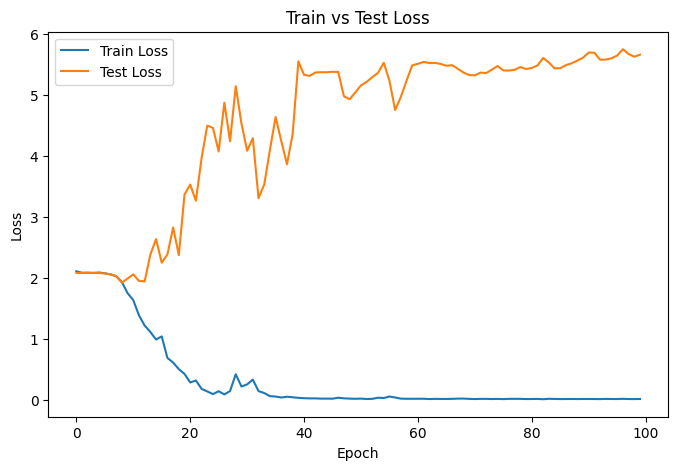

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()

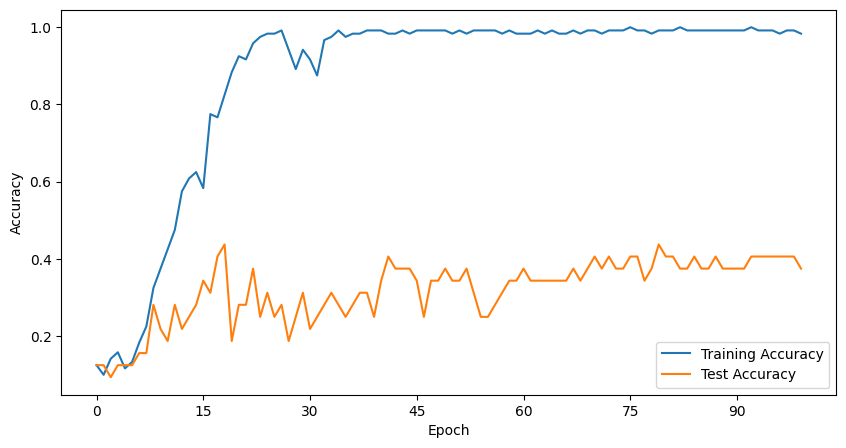

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # make x axis integers
plt.show()